In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_*/*.dat")

In [4]:
len(files)

1320

In [5]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    return float(linhas[16400+7][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 276.3862706481477 dias


In [7]:
energias_iniciais_multicanal = ['1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [8]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [9]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith(energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        n_particulas = float(partes[2].replace('estories','').replace('-','.'))
        dados_ = carrega_dados(file_, n_particulas)
        
        label_ = binarizer.transform([[nuclideo]])

        #Cria o label para o total de contagens do radionuclídeo
        total_counts = np.zeros(label_.shape)
        total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)
        
        dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({'X' : dados_.counts.values,
                                                                                 'n' : n_particulas,
                                                                                 'y': label_,
                                                                                 'y_count' : total_counts,
                                                                                 'd': distancia,
                                                                                 'e': energia_inicial_multicanal})

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Leituras experimentais da GRR

In [10]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [11]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [13]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [42]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [64]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [71]:
X = []
y = []
y_counts = []

In [72]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    for i in range(500):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)

In [73]:
len(X), len(y), len(y_counts)

(2000, 2000, 2000)

## Com os dados gerados pelo PENELOPE

In [74]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['y_count'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels, counts

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [75]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(500):
            values, labels, counts = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'y_count': counts})

In [76]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [77]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [78]:
len(X), len(y), len(y_counts)

(13280, 13280, 13280)

# Modelo

## Dividindo os dados em treino e teste

In [79]:
scaler = StandardScaler()
scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, scaler.transform(y_counts))),
                                                    test_size=0.30,
                                                    random_state=42)

In [80]:
len(X_train), len(X_test), len(y_train), len(y_test)

(9296, 3984, 9296, 3984)

In [81]:
from keras.utils import Sequence

In [82]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [83]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

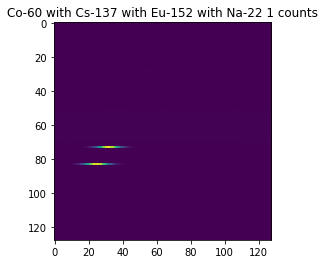

In [84]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.show()

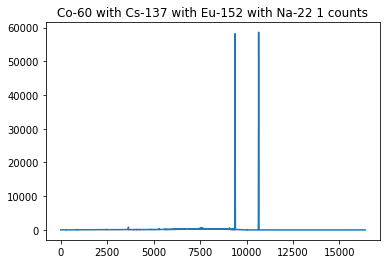

In [85]:
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.plot(a[0].reshape(-1))
plt.show()

In [86]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [88]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)

pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

#pred_counts = keras.layers.Dense(4096, activation='elu')(x1)
#pred_counts = keras.layers.Dense(2048, activation='elu')(pred_counts)
pred_counts = keras.layers.Dense(10, activation=None, name="predictions_counts")(x1)

#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
_____________________________________

In [89]:
learning_rate = 1e-4
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [90]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=opt,
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [ ]:
!nvidia-smi

In [91]:
!rm -rf ./logs

In [92]:
"""

nao funciona bem com multiplas saidas...

class TensorBoardWrapper(keras.callbacks.TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super(TensorBoardWrapper, self).__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps   # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros(((self.nb_steps * ib.shape[0],) + ib.shape[1:]), dtype=np.float32)
                tags = np.zeros(((self.nb_steps * tb.shape[0],) + tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0]), 0.0]
        return super(TensorBoardWrapper, self).on_epoch_end(epoch, logs)
"""

"\n\nnao funciona bem com multiplas saidas...\n\nclass TensorBoardWrapper(keras.callbacks.TensorBoard):\n    '''Sets the self.validation_data property for use with TensorBoard callback.'''\n\n    def __init__(self, batch_gen, nb_steps, **kwargs):\n        super(TensorBoardWrapper, self).__init__(**kwargs)\n        self.batch_gen = batch_gen # The generator.\n        self.nb_steps = nb_steps   # Number of times to call next() on the generator.\n\n    def on_epoch_end(self, epoch, logs):\n        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.\n        # Below is an example that yields images and classification tags.\n        # After it's filled in, the regular on_epoch_end method has access to the validation_data.\n        imgs, tags = None, None\n        for s in range(self.nb_steps):\n            ib, tb = next(self.batch_gen)\n            if imgs is None and tags is None:\n                imgs = np.zeros(((self.nb_steps * ib.shape[0],)

In [93]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=10)

tb = keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 107s - loss: 0.9557 - predictions_nuclei_loss: 0.5801 - predictions_counts_loss: 0.3756 - predictions_nuclei_my_accuracy_score: 0.0098 - predictions_nuclei_acc: 0.8206 - predictions_counts_mean_squared_error: 0.3756 - predictions_counts_mean_absolute_error: 0.3444 - val_loss: 0.8235 - val_predictions_nuclei_loss: 0.5477 - val_predictions_counts_loss: 0.2757 - val_predictions_nuclei_my_accuracy_score: 0.0183 - val_predictions_nuclei_acc: 0.8376 - val_predictions_counts_mean_squared_error: 0.2757 - val_predictions_counts_mean_absolute_error: 0.2899
Epoch 2/250
 - 106s - loss: 0.7826 - predictions_nuclei_loss: 0.5361 - predictions_counts_loss: 0.2465 - predictions_nuclei_my_accuracy_score: 0.0256 - predictions_nuclei_acc: 0.8399 - predictions_counts_mean_squared_error: 0.2465 - predictions_counts_mean_absolute_error: 0.2545 - val_loss: 0.7406 - val_predictions_nuclei_loss: 0.5236 - val_predictions_counts_loss: 0.2170 - val_pre

Epoch 15/250
 - 106s - loss: 0.3978 - predictions_nuclei_loss: 0.3110 - predictions_counts_loss: 0.0868 - predictions_nuclei_my_accuracy_score: 0.1169 - predictions_nuclei_acc: 0.8825 - predictions_counts_mean_squared_error: 0.0868 - predictions_counts_mean_absolute_error: 0.1170 - val_loss: 0.4129 - val_predictions_nuclei_loss: 0.3196 - val_predictions_counts_loss: 0.0933 - val_predictions_nuclei_my_accuracy_score: 0.1283 - val_predictions_nuclei_acc: 0.8816 - val_predictions_counts_mean_squared_error: 0.0933 - val_predictions_counts_mean_absolute_error: 0.1447
Epoch 16/250
 - 106s - loss: 0.3845 - predictions_nuclei_loss: 0.3001 - predictions_counts_loss: 0.0844 - predictions_nuclei_my_accuracy_score: 0.1302 - predictions_nuclei_acc: 0.8865 - predictions_counts_mean_squared_error: 0.0844 - predictions_counts_mean_absolute_error: 0.1161 - val_loss: 0.4223 - val_predictions_nuclei_loss: 0.3110 - val_predictions_counts_loss: 0.1112 - val_predictions_nuclei_my_accuracy_score: 0.1330 - va

Epoch 30/250
 - 106s - loss: 0.2108 - predictions_nuclei_loss: 0.1569 - predictions_counts_loss: 0.0539 - predictions_nuclei_my_accuracy_score: 0.3328 - predictions_nuclei_acc: 0.9425 - predictions_counts_mean_squared_error: 0.0539 - predictions_counts_mean_absolute_error: 0.1038 - val_loss: 0.2337 - val_predictions_nuclei_loss: 0.1782 - val_predictions_counts_loss: 0.0555 - val_predictions_nuclei_my_accuracy_score: 0.3432 - val_predictions_nuclei_acc: 0.9406 - val_predictions_counts_mean_squared_error: 0.0555 - val_predictions_counts_mean_absolute_error: 0.1031
Epoch 31/250
 - 106s - loss: 0.2028 - predictions_nuclei_loss: 0.1489 - predictions_counts_loss: 0.0539 - predictions_nuclei_my_accuracy_score: 0.3460 - predictions_nuclei_acc: 0.9448 - predictions_counts_mean_squared_error: 0.0539 - predictions_counts_mean_absolute_error: 0.1041 - val_loss: 0.2173 - val_predictions_nuclei_loss: 0.1683 - val_predictions_counts_loss: 0.0489 - val_predictions_nuclei_my_accuracy_score: 0.3695 - va

Epoch 45/250
 - 106s - loss: 0.1030 - predictions_nuclei_loss: 0.0784 - predictions_counts_loss: 0.0246 - predictions_nuclei_my_accuracy_score: 0.5700 - predictions_nuclei_acc: 0.9715 - predictions_counts_mean_squared_error: 0.0246 - predictions_counts_mean_absolute_error: 0.0775 - val_loss: 0.1383 - val_predictions_nuclei_loss: 0.1085 - val_predictions_counts_loss: 0.0298 - val_predictions_nuclei_my_accuracy_score: 0.5634 - val_predictions_nuclei_acc: 0.9668 - val_predictions_counts_mean_squared_error: 0.0298 - val_predictions_counts_mean_absolute_error: 0.0863
Epoch 46/250
 - 106s - loss: 0.1002 - predictions_nuclei_loss: 0.0759 - predictions_counts_loss: 0.0244 - predictions_nuclei_my_accuracy_score: 0.5852 - predictions_nuclei_acc: 0.9725 - predictions_counts_mean_squared_error: 0.0244 - predictions_counts_mean_absolute_error: 0.0779 - val_loss: 0.1338 - val_predictions_nuclei_loss: 0.1052 - val_predictions_counts_loss: 0.0287 - val_predictions_nuclei_my_accuracy_score: 0.5624 - va

Epoch 60/250
 - 106s - loss: 0.0596 - predictions_nuclei_loss: 0.0454 - predictions_counts_loss: 0.0142 - predictions_nuclei_my_accuracy_score: 0.7128 - predictions_nuclei_acc: 0.9837 - predictions_counts_mean_squared_error: 0.0142 - predictions_counts_mean_absolute_error: 0.0661 - val_loss: 0.1002 - val_predictions_nuclei_loss: 0.0818 - val_predictions_counts_loss: 0.0184 - val_predictions_nuclei_my_accuracy_score: 0.6904 - val_predictions_nuclei_acc: 0.9734 - val_predictions_counts_mean_squared_error: 0.0184 - val_predictions_counts_mean_absolute_error: 0.0763
Epoch 61/250
 - 106s - loss: 0.0574 - predictions_nuclei_loss: 0.0436 - predictions_counts_loss: 0.0138 - predictions_nuclei_my_accuracy_score: 0.7276 - predictions_nuclei_acc: 0.9842 - predictions_counts_mean_squared_error: 0.0138 - predictions_counts_mean_absolute_error: 0.0655 - val_loss: 0.0929 - val_predictions_nuclei_loss: 0.0773 - val_predictions_counts_loss: 0.0156 - val_predictions_nuclei_my_accuracy_score: 0.6909 - va

Epoch 75/250
 - 106s - loss: 0.0369 - predictions_nuclei_loss: 0.0285 - predictions_counts_loss: 0.0084 - predictions_nuclei_my_accuracy_score: 0.8006 - predictions_nuclei_acc: 0.9901 - predictions_counts_mean_squared_error: 0.0084 - predictions_counts_mean_absolute_error: 0.0565 - val_loss: 0.0882 - val_predictions_nuclei_loss: 0.0737 - val_predictions_counts_loss: 0.0145 - val_predictions_nuclei_my_accuracy_score: 0.7370 - val_predictions_nuclei_acc: 0.9768 - val_predictions_counts_mean_squared_error: 0.0145 - val_predictions_counts_mean_absolute_error: 0.0698
Epoch 76/250
 - 106s - loss: 0.0348 - predictions_nuclei_loss: 0.0265 - predictions_counts_loss: 0.0082 - predictions_nuclei_my_accuracy_score: 0.8065 - predictions_nuclei_acc: 0.9904 - predictions_counts_mean_squared_error: 0.0082 - predictions_counts_mean_absolute_error: 0.0551 - val_loss: 0.0956 - val_predictions_nuclei_loss: 0.0788 - val_predictions_counts_loss: 0.0168 - val_predictions_nuclei_my_accuracy_score: 0.7287 - va

Epoch 90/250
 - 106s - loss: 0.0238 - predictions_nuclei_loss: 0.0181 - predictions_counts_loss: 0.0057 - predictions_nuclei_my_accuracy_score: 0.8568 - predictions_nuclei_acc: 0.9940 - predictions_counts_mean_squared_error: 0.0057 - predictions_counts_mean_absolute_error: 0.0489 - val_loss: 0.0920 - val_predictions_nuclei_loss: 0.0747 - val_predictions_counts_loss: 0.0173 - val_predictions_nuclei_my_accuracy_score: 0.7868 - val_predictions_nuclei_acc: 0.9797 - val_predictions_counts_mean_squared_error: 0.0173 - val_predictions_counts_mean_absolute_error: 0.0773


In [94]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-classificacao-regressao-PENELOPE.hdf5')

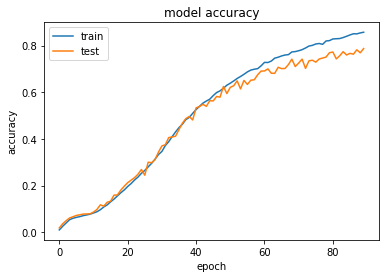

In [95]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

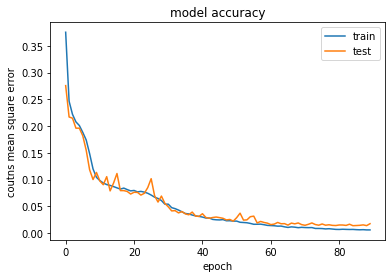

In [96]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

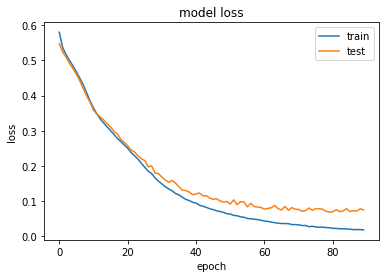

In [97]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Validando nos espectros criados com Penelope

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

471


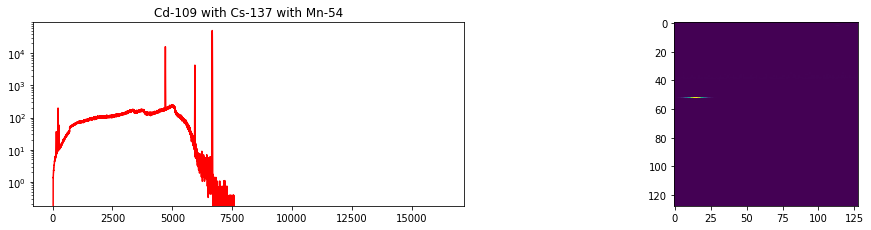

In [98]:
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [99]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [100]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': scaler.inverse_transform(y_counts[idx])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,2.02,"-12,076.22",0.00
1,Ba-133,0.00,"22,526.71",0.00
2,Cd-109,83.20,"-1,095.28",175.27
3,Co-57,0.00,"-7,265.59",0.00
4,Co-60,0.00,"-38,946.95",-0.00
5,Cs-137,100.00,"272,911.03","299,919.26"
6,Eu-152,0.00,"127,130.27",0.00
7,Mn-54,100.00,"1,111,812.62","1,051,984.23"
8,Na-22,0.03,"-56,804.11",0.00
9,Pb-210,0.00,"-1,975.68",0.00


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [101]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [102]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [ ]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [103]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"156,843.97","141,596.00"
1,Ba-133,0.00,"6,547.49","141,596.00"
2,Cd-109,0.44,509.56,"141,596.00"
3,Co-57,1.16,-282.09,"141,596.00"
4,Co-60,0.00,"-38,092.17","141,596.00"
5,Cs-137,0.00,"-6,542.53","141,596.00"
6,Eu-152,0.00,-227.77,"141,596.00"
7,Mn-54,0.01,"-2,027.15","141,596.00"
8,Na-22,0.00,"-31,816.06","141,596.00"
9,Pb-210,0.05,-987.20,"141,596.00"


In [104]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,171.72,"35,319.00"
1,Ba-133,100.00,"46,870.61","35,319.00"
2,Cd-109,1.94,-62.01,"35,319.00"
3,Co-57,1.68,-837.80,"35,319.00"
4,Co-60,0.00,"-17,243.89","35,319.00"
5,Cs-137,0.00,"4,677.87","35,319.00"
6,Eu-152,0.00,"-3,583.81","35,319.00"
7,Mn-54,0.12,"-1,094.93","35,319.00"
8,Na-22,0.00,"-12,982.70","35,319.00"
9,Pb-210,0.42,224.96,"35,319.00"


In [105]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"-2,815.64","7,195.00"
1,Ba-133,0.00,"1,747.57","7,195.00"
2,Cd-109,95.63,"19,246.24","7,195.00"
3,Co-57,0.01,480.93,"7,195.00"
4,Co-60,0.00,"-23,832.84","7,195.00"
5,Cs-137,0.00,992.91,"7,195.00"
6,Eu-152,0.00,"-14,773.09","7,195.00"
7,Mn-54,0.02,"-12,043.12","7,195.00"
8,Na-22,0.00,"-35,888.12","7,195.00"
9,Pb-210,0.00,152.26,"7,195.00"


In [106]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,21.66,"7,323.00"
1,Ba-133,0.00,"1,414.46","7,323.00"
2,Cd-109,0.11,271.20,"7,323.00"
3,Co-57,97.72,"20,450.46","7,323.00"
4,Co-60,0.00,"-23,692.70","7,323.00"
5,Cs-137,0.00,"-3,052.72","7,323.00"
6,Eu-152,0.00,"3,158.72","7,323.00"
7,Mn-54,0.07,"-7,619.23","7,323.00"
8,Na-22,0.00,"1,821.89","7,323.00"
9,Pb-210,0.00,-247.46,"7,323.00"


In [107]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,-969.98,"155,643.00"
1,Ba-133,0.00,"-2,468.46","155,643.00"
2,Cd-109,0.03,518.89,"155,643.00"
3,Co-57,0.05,411.13,"155,643.00"
4,Co-60,100.00,"178,747.75","155,643.00"
5,Cs-137,0.00,"8,588.97","155,643.00"
6,Eu-152,0.00,"37,479.48","155,643.00"
7,Mn-54,0.07,"5,974.80","155,643.00"
8,Na-22,0.00,"-7,828.39","155,643.00"
9,Pb-210,0.00,-125.08,"155,643.00"


In [108]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"-5,997.64","188,461.00"
1,Ba-133,0.04,"2,226.51","188,461.00"
2,Cd-109,0.04,-403.09,"188,461.00"
3,Co-57,0.14,"-2,497.73","188,461.00"
4,Co-60,0.00,"8,206.91","188,461.00"
5,Cs-137,100.00,"212,503.97","188,461.00"
6,Eu-152,0.00,"13,928.09","188,461.00"
7,Mn-54,0.03,"7,649.65","188,461.00"
8,Na-22,0.03,"5,069.48","188,461.00"
9,Pb-210,0.00,"-2,084.36","188,461.00"


In [109]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.78,-867.70,"94,419.00"
1,Ba-133,0.07,"-5,084.54","94,419.00"
2,Cd-109,0.24,-252.42,"94,419.00"
3,Co-57,4.27,"3,677.73","94,419.00"
4,Co-60,0.00,"-5,680.00","94,419.00"
5,Cs-137,0.00,"5,404.67","94,419.00"
6,Eu-152,100.00,"118,753.54","94,419.00"
7,Mn-54,0.04,"5,871.03","94,419.00"
8,Na-22,0.00,"6,697.70","94,419.00"
9,Pb-210,0.74,"-1,144.94","94,419.00"


In [110]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"-3,508.00","7,159.00"
1,Ba-133,0.00,"1,292.41","7,159.00"
2,Cd-109,0.00,-327.67,"7,159.00"
3,Co-57,0.02,"1,814.47","7,159.00"
4,Co-60,0.00,"-11,833.67","7,159.00"
5,Cs-137,0.00,"-1,484.40","7,159.00"
6,Eu-152,0.00,"-3,599.46","7,159.00"
7,Mn-54,94.22,"13,166.48","7,159.00"
8,Na-22,0.00,"-17,366.86","7,159.00"
9,Pb-210,0.00,-155.01,"7,159.00"


In [111]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"-1,835.54","7,965.00"
1,Ba-133,0.00,"1,193.90","7,965.00"
2,Cd-109,0.01,105.77,"7,965.00"
3,Co-57,0.00,"3,178.99","7,965.00"
4,Co-60,0.00,"-44,252.39","7,965.00"
5,Cs-137,0.00,"2,157.69","7,965.00"
6,Eu-152,0.00,"-13,762.93","7,965.00"
7,Mn-54,0.15,"-3,533.78","7,965.00"
8,Na-22,81.70,"5,723.81","7,965.00"
9,Pb-210,0.00,"-1,060.93","7,965.00"


In [112]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,7.94,"-3,862.73","19,650.00"
1,Ba-133,0.00,677.95,"19,650.00"
2,Cd-109,2.00,-605.62,"19,650.00"
3,Co-57,0.47,"1,301.93","19,650.00"
4,Co-60,0.00,"2,444.39","19,650.00"
5,Cs-137,0.00,"-8,941.43","19,650.00"
6,Eu-152,0.00,"3,441.76","19,650.00"
7,Mn-54,0.01,"-6,232.91","19,650.00"
8,Na-22,0.00,"-2,403.86","19,650.00"
9,Pb-210,100.00,"33,572.22","19,650.00"


## Fonte triplice de calibração

In [113]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

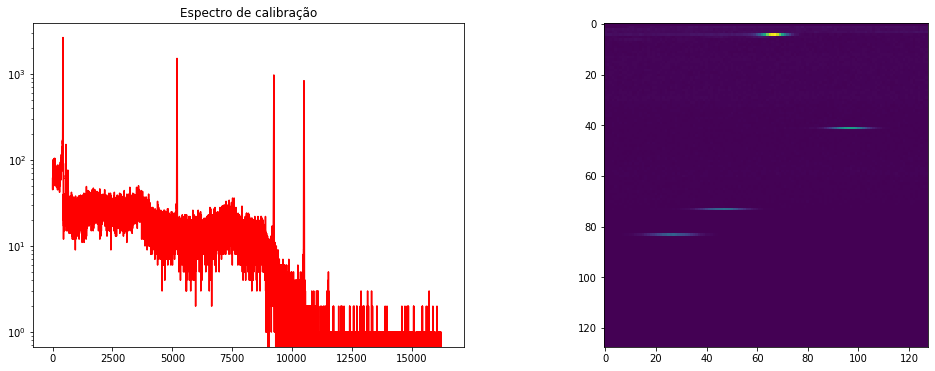

In [114]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [115]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,6.59,"62,808.34","276,428.00"
1,Ba-133,0.00,"61,093.97","276,428.00"
2,Cd-109,0.32,"-7,683.72","276,428.00"
3,Co-57,4.72,"11,145.33","276,428.00"
4,Co-60,100.00,"263,036.62","276,428.00"
5,Cs-137,100.00,"60,148.20","276,428.00"
6,Eu-152,0.04,"48,454.50","276,428.00"
7,Mn-54,0.07,"6,391.46","276,428.00"
8,Na-22,0.02,"-24,229.88","276,428.00"
9,Pb-210,59.44,"6,452.45","276,428.00"
